In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from keras.metrics import Precision, Recall, AUC, CategoricalAccuracy

from custom_models.augmentation import basic_plus_color_augmentation, basic_augmentation
from custom_models.bilinear_cnns import fe_resnet
from custom_models.cnns import simple_cnn_bn, base_resnet50
from custom_models.optimization_utilities import get_standard_callbacks
from etl.load_dataset import DatasetProcessor, get_tf_eggim_patch_dataset
from optimization.custom_losses import weighted_categorical_crossentropy

In [7]:
target_dir = '../Dataset'
model_weights_directory = '../logs/'
batch_size = 32
num_epochs = 100
learning_rate = 1e-4
num_folds = 5
name = f'cv_patient_resnet_multi'
model_fold_dir = sorted(os.listdir(model_weights_directory))
model_dirs = [os.path.join(os.path.join(model_weights_directory, x), 'weights.h5')
              for x in model_fold_dir if x.startswith(name)]

In [8]:
model_dirs

['../logs/cv_patient_resnet_multi_8fold_0_20241227-153706/weights.h5',
 '../logs/cv_patient_resnet_multi_8fold_1_20241227-153823/weights.h5',
 '../logs/cv_patient_resnet_multi_8fold_2_20241227-153934/weights.h5',
 '../logs/cv_patient_resnet_multi_8fold_3_20241227-154045/weights.h5',
 '../logs/cv_patient_resnet_multi_8fold_4_20241227-154159/weights.h5',
 '../logs/cv_patient_resnet_multi_8fold_5_20241227-154312/weights.h5',
 '../logs/cv_patient_resnet_multi_8fold_6_20241227-154421/weights.h5',
 '../logs/cv_patient_resnet_multi_8fold_7_20241227-154531/weights.h5']

In [9]:
dp = DatasetProcessor(target_dir)
df = dp.process()
patient_ids = np.load('configs/test_patient_ids.npy', allow_pickle=True)

togas_ids_boolean = np.array([x.startswith('PT') for x in df['patient_id'].values])
df_togas = df[togas_ids_boolean].reset_index(drop=True)
df_ipo = df[~togas_ids_boolean].reset_index(drop=True)


In [10]:
from sklearn.metrics import confusion_matrix

from evaluation.metrics import categorical_accuracy

from evaluation.metrics import specificity_per_class

from evaluation.metrics import sensitivity_per_class

metrics = []
y_true_ordinals = []
y_pred_ordinals = []
split = dp.patient_wise_split(df_togas,
                                      df_ipo,
                                      patient_ids,
                                      internal_train_size=0.9,
                                      target_variable='eggim_square',
                                      random_state=42)
for fold, (df_train, df_val, df_test) in enumerate(split):
    tf_test_df = get_tf_eggim_patch_dataset(df_test,
                                            num_classes=3,
                                            preprocess_fn=tf.keras.applications.resnet.preprocess_input)

    tf_test_df = tf_test_df.batch(batch_size)

    n_classes = 3  # Replace with the number of classes you have
    model = base_resnet50(input_shape=(224, 224, 3), n_classes=n_classes)
    # Compile the model with Adam optimizer 13:21
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=[CategoricalAccuracy(name='cat_accuracy'), Precision(name='precision'),
                           Recall(name='recall'),
                           AUC(name='auc')])


    model.load_weights(model_dirs[fold])

    y_true = np.concatenate([y for (_, y) in tf_test_df])
    y_pred = model.predict(tf_test_df)
    y_true_ordinal = np.argmax(y_true, axis=-1) # [0 0 1] -> 2
    y_pred_ordinal = np.argmax(y_pred, axis=-1)
    y_true_ordinals.append(y_true_ordinal)
    y_pred_ordinals.append(y_pred_ordinal)
    y_pred_one_hot = np.zeros_like(y_pred)
    y_pred_one_hot[np.arange(len(y_pred)), np.argmax(y_pred, axis=1)] = 1 # [0.2, 0.2, 0.6] -> [0, 0, 1]
    print(y_pred)
    print(y_pred_ordinal)
    print(y_pred_one_hot)
    conf_matrix = confusion_matrix(y_true_ordinal, y_pred_ordinal,
                                   labels=[0, 1, 2])
    metrics.append([categorical_accuracy(y_true, y_pred_one_hot),
                    specificity_per_class(conf_matrix), sensitivity_per_class(conf_matrix),
                    conf_matrix])

1/1 [==============================] - 1s 1s/step
[[0.56523556 0.2790574  0.15570714]
 [0.16536276 0.3821388  0.45249832]
 [0.06217721 0.23014277 0.70768   ]
 [0.61429447 0.2018537  0.18385167]
 [0.11121094 0.26314548 0.6256436 ]
 [0.52392954 0.31840366 0.15766689]
 [0.12417749 0.4883465  0.38747603]
 [0.10509816 0.41261542 0.48228624]
 [0.00223072 0.08950961 0.90825963]
 [0.18564774 0.5257379  0.28861448]
 [0.27773902 0.4076131  0.31464788]]
[0 2 2 0 2 0 1 2 2 1 1]
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]
1/1 [==============================] - 1s 1s/step
[[0.24678656 0.18176247 0.57145095]
 [0.02786118 0.6214213  0.3507175 ]
 [0.18470438 0.5935898  0.22170587]
 [0.09263751 0.09120128 0.8161613 ]
 [0.805256   0.02256961 0.17217427]
 [0.03070955 0.10141562 0.8678749 ]
 [0.02477321 0.02441866 0.950808  ]
 [0.03197021 0.48457015 0.48345968]
 [0.01865564 0.3783494  0.6029949 ]
 [0.34502986 0.4082546

/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)


1/1 [==============================] - 1s 1s/step
[[0.17678042 0.443084   0.38013545]
 [0.04469569 0.40997702 0.54532737]
 [0.05368268 0.51088816 0.43542928]
 [0.12417804 0.17646487 0.69935715]
 [0.06394619 0.492505   0.44354877]
 [0.29218948 0.46202257 0.245788  ]
 [0.00199963 0.04761716 0.9503832 ]
 [0.14849663 0.14370653 0.70779675]
 [0.02006977 0.8568842  0.12304606]
 [0.0283222  0.41588247 0.55579525]
 [0.06519969 0.57180965 0.36299065]
 [0.02408409 0.56197584 0.41394007]
 [0.0322966  0.15202141 0.815682  ]
 [0.04206778 0.30237797 0.6555543 ]]
[1 2 1 2 1 1 2 2 1 2 1 1 2 2]
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]
1/1 [==============================] - 1s 1s/step
[[0.62661576 0.24560237 0.12778194]
 [0.8172818  0.04018736 0.14253092]
 [0.57538295 0.1874686  0.23714851]
 [0.35305816 0.28831232 0.3586295 ]
 [0.8419934  0.00498376 0.15302289]
 [0.28609645 0.5

/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:27: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)
/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)


1/1 [==============================] - 1s 1s/step
[[0.17278545 0.28698874 0.5402259 ]
 [0.65995413 0.1741822  0.16586371]
 [0.08138472 0.11489362 0.80372167]
 [0.852637   0.01756562 0.1297974 ]
 [0.83280367 0.09851184 0.06868442]
 [0.7780056  0.10984682 0.1121476 ]
 [0.9584694  0.00444773 0.03708284]
 [0.13430808 0.40746063 0.45823118]
 [0.10189965 0.16310208 0.73499835]
 [0.06342284 0.40934226 0.52723485]
 [0.30545104 0.19418165 0.50036734]
 [0.9265523  0.00739707 0.0660506 ]
 [0.49813455 0.31458285 0.18728252]]
[2 0 2 0 0 0 0 2 2 2 2 0 0]
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)


1/1 [==============================] - 1s 1s/step
[[0.04403049 0.11577044 0.84019905]
 [0.01292423 0.0532936  0.93378216]
 [0.02365302 0.23690864 0.7394383 ]
 [0.01237729 0.27938676 0.708236  ]
 [0.07273357 0.43597713 0.4912892 ]
 [0.537043   0.08291907 0.380038  ]
 [0.02434901 0.27174813 0.7039029 ]
 [0.01283468 0.22674051 0.76042473]
 [0.06995802 0.10510394 0.82493806]
 [0.15220085 0.38125086 0.46654832]]
[2 2 2 2 2 0 2 2 2 2]
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:27: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)
/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)


1/1 [==============================] - 1s 1s/step
[[0.01478834 0.0818165  0.9033952 ]
 [0.04909779 0.21120654 0.73969567]
 [0.0050126  0.09364208 0.90134525]
 [0.00633859 0.11955712 0.87410426]
 [0.00508035 0.1847826  0.8101371 ]
 [0.11854453 0.10152986 0.7799255 ]
 [0.00613191 0.04126041 0.95260763]
 [0.00713076 0.11215132 0.8807179 ]
 [0.05391379 0.1713813  0.77470493]
 [0.04248175 0.283807   0.67371124]
 [0.00364987 0.00984244 0.98650765]
 [0.01708439 0.17963432 0.8032813 ]]
[2 2 2 2 2 2 2 2 2 2 2 2]
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)


In [11]:
cat_acc = np.array([x[0] for x in metrics])
spec = np.array([x[1] for x in metrics])
sens = np.array([x[2] for x in metrics])
confs = np.array([x[3] for x in metrics], dtype=object)

/tmp/ipykernel_17872/4237036052.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Cat Acc', 'Spec', 'Sens'])


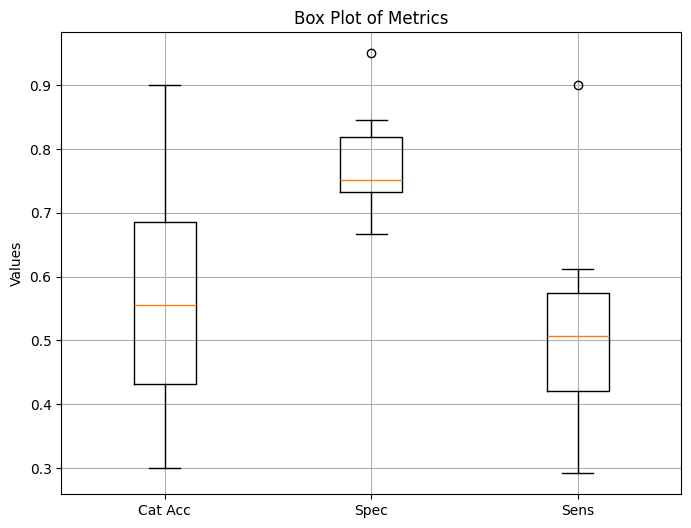

In [12]:
data = [cat_acc, np.nanmean(spec, axis=1), np.nanmean(sens, axis=1)]

# Create the box plot
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=['Cat Acc', 'Spec', 'Sens'])
plt.title('Box Plot of Metrics')
plt.ylabel('Values')
plt.grid(True)

# Show the plot
plt.show()

In [13]:
from evaluation.eggim import *
def replace_landmark_name(landmark):
    new_landmark_name = {'ii': 'distal body',
                    'ix': 'distal lc',
                    'vi': 'proximal ant lc',
                    'vii': 'proximal ant gc/pw',
                    'viii': 'incisura r',
                    'x': 'upper body r',
                    'xii': 'upper body ant'}
    landmark_number = landmark.split('.')[0]
    return new_landmark_name[landmark_number]

dp = DatasetProcessor(target_dir)
df = dp.process()
df['landmark'] = df['landmark'].apply(replace_landmark_name)
patient_ids = np.load('configs/test_patient_ids.npy', allow_pickle=True)

togas_ids_boolean = np.array([x.startswith('PT') for x in df['patient_id'].values])
df_togas = df[togas_ids_boolean].reset_index(drop=True)
df_ipo = df[~togas_ids_boolean].reset_index(drop=True)


In [14]:
def compute_eggim_patient(patient_df, target_variable):
    df = patient_df[['landmark', target_variable]].value_counts()
    # we use index[0] to assume first landmark/score pair is correct
    eggim_antrum_incisura = df['proximal ant lc'].index[0] + df['proximal ant gc/pw'].index[0] + df['incisura r'].index[0]
    eggim_body_1 = (df['distal body'].index[0] + df['upper body ant'].index[0]) / 2
    eggim_body_2 = (df['distal lc'].index[0]+ df['upper body r'].index[0]) / 2
    return eggim_antrum_incisura + eggim_body_1 + eggim_body_2

eggim_scores = {}
for i, patient_id in enumerate(patient_ids):
    print(patient_id)
    df_patient = df_togas[df_togas['patient_id'] == patient_id]
    df_patient['pred'] = y_pred_ordinals[i]
    eggim_square = compute_eggim_patient(df_patient,
                                          target_variable='eggim_square')
    eggim_global = compute_eggim_patient(df_patient,
                                  target_variable='eggim_global')
    eggim_pred = compute_eggim_patient(df_patient,
                                  target_variable='pred')
    eggim_scores[patient_ids[i]] = {'eggim_square': eggim_square, 'eggim_global': eggim_global,
                                    'eggim_pred': eggim_pred}
eggim_df = pd.DataFrame(eggim_scores).T

PT004
PT005
PT006
PT009
PT016
PT020
PT021
PT022


/tmp/ipykernel_17872/2628975875.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patient['pred'] = y_pred_ordinals[i]
/tmp/ipykernel_17872/2628975875.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patient['pred'] = y_pred_ordinals[i]
/tmp/ipykernel_17872/2628975875.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [15]:
eggim_df

,eggim_square,eggim_global,eggim_pred
PT004,1.0,1.0,5.0
PT005,4.0,3.0,6.0
PT006,1.0,1.0,5.0
PT009,8.0,8.5,7.0
PT016,0.0,0.0,4.5
PT020,1.0,2.0,6.0
PT021,10.0,10.0,9.0
PT022,8.0,8.0,10.0


In [16]:
# minimum error of patch vs global labels
best_possible_eggim_mae = np.mean(np.abs(eggim_df.iloc[:, 1] -  eggim_df.iloc[:, 0]))

In [17]:
# error of patch predictions vs patch labels
patch_eggim_mae =  np.mean(np.abs(eggim_df.iloc[:, 0] -  eggim_df.iloc[:, 2]))

In [18]:
patch_global_eggim_mae = np.mean(np.abs(eggim_df.iloc[:, 1] -  eggim_df.iloc[:, 2]))

In [19]:
patch_eggim_mae

2.9375

In [20]:
# patch ground truth vs patch pred:
patch_eggim_mae

2.9375

In [21]:
# global ground truth vs patch pred
patch_global_eggim_mae

3.0

In [22]:
# global ground truth vs patch pred "adjusted" with minimum error in square labels
patch_global_eggim_mae - best_possible_eggim_mae

2.6875

In [23]:
best_possible_eggim_mae

0.3125